In [1]:
import os, time, random, math, pickle, json, shutil
from pathlib import Path
from datetime import datetime

import torch, torchvision
from torchinfo import summary
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import autocast, GradScaler

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_FILE          = "data/dots100k_128.pt"   # path to the .pt with {"frames","disp"}
BATCH_SZ           = 256
NUM_EPOCHS         = 15
LR                 = 2e-4
WEIGHT_DECAY       = 1e-4
RESNET_DEPTH       = 18       # choose 18, 34, 50, 101 …
PRETRAINED         = False    # if True, load ImageNet weights then patch 1st conv
USE_GRAYSCALE      = False    # if True, convert f0,f1,diff to 1-channel each

TRAIN_FRACTION     = 0.8      # 80 % train, 10 % val, 10 % test
VAL_FRACTION       = 0.1

DEVICE             = "cuda" if torch.cuda.is_available() else "cpu"

# Experiment folder
# EXP_DIR = Path(f"experiments/flowcount_ResNet18_L1")
EXP_DIR = Path(f"experiments/exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
EXP_DIR.mkdir(parents=True, exist_ok=True)
print(f"Logging to → {EXP_DIR.resolve()}")

Logging to → C:\Users\Owner\Documents\FlowCount\experiments\exp_20250612_153028


## Prepare Dataset

In [3]:
def normalize(t, mean=0, std=1): return (t-mean)/std
def unnormalize(t, mean=0, std=1): return (t*std)+mean

In [4]:
class DotPairDataset(Dataset):
    """
    Each item:
        x : Tensor  (C,H,W)  where C = 9 (RGB+diff) or 3 (gray+diff)
        y : scalar float     normalized displacement
    """
    def __init__(self,
                 frames_uint8,            # (N+1,3,H,W) uint8
                 disp_int32,              # (N,)      int32
                 channel_means,           # (C,)      float
                 channel_stds,            # (C,)      float
                 disp_mean, disp_std,
                 grayscale=False):
        assert frames_uint8.dtype == torch.uint8
        self.F            = frames_uint8
        self.disp         = disp_int32.float()
        self.ch_means     = channel_means.view(-1,1,1)
        self.ch_stds      = channel_stds.view(-1,1,1)
        self.disp_mean    = disp_mean
        self.disp_std     = disp_std
        self.gray         = grayscale

    def __len__(self):
        # we have one fewer diff than frames
        return self.disp.shape[0]

    def __getitem__(self, idx):
        # raw frames
        f0 = self.F[idx].float()    # → (3,H,W) in [0,255]
        f1 = self.F[idx+1].float()

        # continuous diff channel in [-1,1]
        diff = (f1 - f0).div(255.0)

        if not self.gray:
            # stack: [R0,G0,B0, R1,G1,B1, dR,dG,dB]
            x = torch.cat([f0, f1, diff], dim=0)
        else:
            # convert each to gray (0..255) then to [0,1]
            to_gray = lambda im: ((0.299*im[0] + 0.587*im[1] + 0.114*im[2]) / 255.0).unsqueeze(0)
            g0 = to_gray(f0); g1 = to_gray(f1); gd = diff.mean(dim=0, keepdim=True)
            x = torch.cat([g0, g1, gd], dim=0)  # (3,H,W)

        # now x is in roughly [0,1] except diff in [-1,1]
        # normalize *all* channels to zero-mean/unit-variance
        x = (x - self.ch_means) / self.ch_stds

        # normalize target
        y = (self.disp[idx] - self.disp_mean) / self.disp_std
        return x, y

In [5]:
raw = torch.load(DATA_FILE)
frames_u8, disp_i32 = raw["frames"], raw["disp"]

# Calculate means/stds for all frame channels
flat = frames_u8.float().view( frames_u8.shape[0] * 3, -1 ) / 255.0
f0 = frames_u8[:-1].float()
f1 = frames_u8[1:].float()
diff = (f1 - f0).div(255.0)
flat_diff = diff.view(diff.shape[0]*3, -1)
all_flat = torch.cat([flat, flat_diff], dim=0)
means = all_flat.mean(dim=1)
stds  = all_flat.std(dim=1)
channel_means = means.reshape(-1,1,1)
channel_stds  = stds.reshape(-1,1,1)

# DISP_MEAN = disp_i32.to(torch.float32).mean()
# DISP_STD = disp_i32.to(torch.float32).std()
DISP_MEAN = 0
DISP_STD = 1

full_ds   = DotPairDataset(frames_u8, disp_i32, DISP_MEAN, DISP_STD, grayscale=USE_GRAYSCALE)

n_total   = len(full_ds)
n_train   = int(TRAIN_FRACTION * n_total)
n_val     = int(VAL_FRACTION   * n_total)
n_test    = n_total - n_train - n_val

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test],
                                         generator=torch.Generator().manual_seed(0))

train_ld = DataLoader(train_ds, batch_size=BATCH_SZ, shuffle=True,
                      num_workers=0, pin_memory=True)
val_ld   = DataLoader(val_ds,   batch_size=BATCH_SZ, shuffle=False,
                      num_workers=0, pin_memory=True)
test_ld  = DataLoader(test_ds,  batch_size=BATCH_SZ, shuffle=False,
                      num_workers=0, pin_memory=True)

print(f"Dataset sizes — train: {n_train}, val: {n_val}, test: {n_test}")

C:\Users\Owner\AppData\Local\Temp\ipykernel_42236\2730744880.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(DATA_FILE)


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4372549..0.43333334].


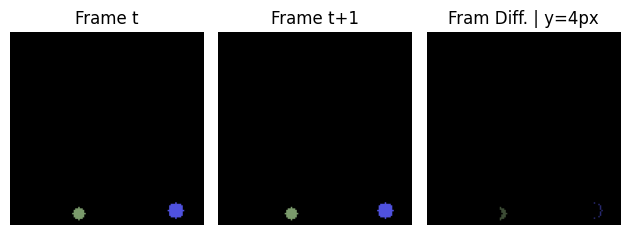

In [ ]:
idx = random.randrange(len(full_ds))
(pair, label) = full_ds[idx]
f0 = pair[0:3].permute(1, 2, 0).numpy()  # (H,W,3)
f1 = pair[3:6].permute(1, 2, 0).numpy()
diff = pair[6:9].permute(1, 2, 0).numpy()

plt.subplot(1, 3, 1)
plt.title("Frame t")
plt.imshow(f0)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Frame t+1")
plt.imshow(f1)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title(f"Fram Diff. | y={int(label.item())}px")
plt.imshow(diff)
plt.axis("off")

plt.tight_layout()
plt.show()

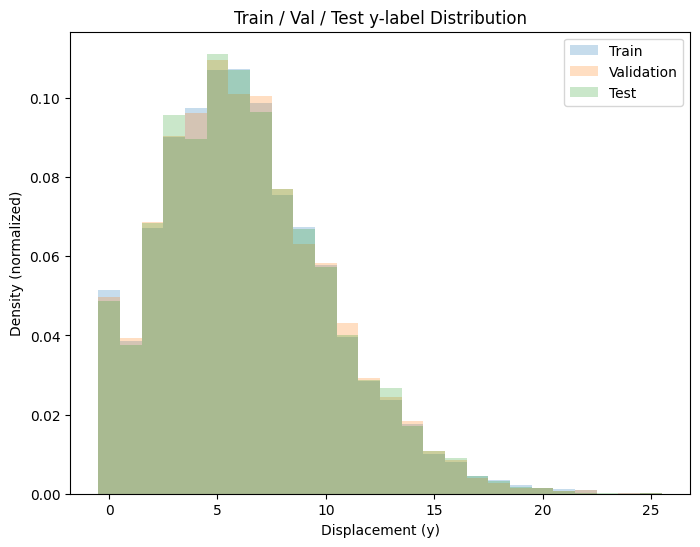

In [ ]:
g    = torch.Generator().manual_seed(0)
perm = torch.randperm(n_total, generator=g)

train_idx = perm[:n_train]
val_idx   = perm[n_train : n_train + n_val]
test_idx  = perm[n_train + n_val :]

# Extract “y” arrays for each split:
y_train = disp_i32[train_idx].numpy() - 0.5
y_val   = disp_i32[val_idx].numpy() - 0.5
y_test  = disp_i32[test_idx].numpy() - 0.5

# -- Plot them together on one figure, with density=True so the y-axis is normalized --
plt.figure(figsize=(8, 6))
bins = 26  # → adjust if you want fewer/more bins

plt.hist(y_train, bins=bins, density=True, alpha=0.25, label='Train')
plt.hist(y_val,   bins=bins, density=True, alpha=0.25, label='Validation')
plt.hist(y_test,  bins=bins, density=True, alpha=0.25, label='Test')

plt.xlabel('Displacement (y)')
plt.ylabel('Density (normalized)')
plt.legend()
plt.title('Train / Val / Test y-label Distribution')
plt.show() 

## Load Model

In [ ]:
def get_resnet(depth=18, in_channels=9, pretrained=False):
    factory = {
        18:  torchvision.models.resnet18,
        34:  torchvision.models.resnet34,
        50:  torchvision.models.resnet50,
        101: torchvision.models.resnet101,
        152: torchvision.models.resnet152,
    }[depth]

    model = factory(weights="IMAGENET1K_V1" if pretrained else None, memory_format=torch.channels_last)
    torch.backends.cudnn.benchmark = True

    # Patch the first conv if channel count differs
    if in_channels != 3:
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(in_channels, w.shape[0],
                                kernel_size=7, stride=2, padding=3, bias=False)
        if pretrained:
            # Kaiming init for new conv
            nn.init.kaiming_normal_(model.conv1.weight, mode="fan_out", nonlinearity="relu")

    # Replace classifier with 1-unit head for regression
    model.fc = nn.Linear(model.fc.in_features, 1)
    return model

C_IN   = 3 if USE_GRAYSCALE else 9
net    = get_resnet(RESNET_DEPTH, in_channels=C_IN, pretrained=PRETRAINED).to(DEVICE)
criterion = nn.L1Loss()
optim     = torch.optim.AdamW(net.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=NUM_EPOCHS)
scaler    = GradScaler(device=DEVICE)

summary(net)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            28,224
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,72

## Train Model

In [ ]:
def run_epoch(model, loader, train=True):
    if train: model.train()
    else:     model.eval()

    total_loss, n_samples = 0.0, 0
    with torch.set_grad_enabled(train):
        for x, y in tqdm(loader, desc="Batch"):
            x, y = x.to(DEVICE), y.float().unsqueeze(1).to(DEVICE)  # (B,1)
            with autocast(device=DEVICE):
                pred = model(x)
                loss = criterion(pred, y)
            if train:
                optim.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optim)
                scaler.update()
                scheduler.step()
            total_loss += loss.item() * x.size(0)
            n_samples  += x.size(0)
    return total_loss / n_samples    # MAE

In [ ]:
train_curve, val_curve, test_curve = [], [], []
best_val = float("inf")

for epoch in trange(1, NUM_EPOCHS+1, desc="Epoch"):
    t0 = time.time()
    tr_loss = run_epoch(net, train_ld, train=True)
    tr_loss = unnormalize(tr_loss, DISP_MEAN, DISP_STD)
    val_loss = run_epoch(net, val_ld,   train=False)
    tr_loss = unnormalize(tr_loss, DISP_MEAN, DISP_STD)
    test_loss = run_epoch(net, test_ld,   train=False)
    test_loss = unnormalize(test_loss, DISP_MEAN, DISP_STD)

    train_curve.append(tr_loss)
    val_curve.append(val_loss)
    test_curve.append(test_loss)

    # -- console log
    print(f"[{epoch:02d}/{NUM_EPOCHS}]  "
          f"train MAE {tr_loss:.4f} | val MAE {val_loss:.4f}  "
          f"({time.time()-t0:.1f}s)")

    # -- checkpointing
    last_path = EXP_DIR / "last_weights.pt"
    best_path = EXP_DIR / "best_weights.pt"
    torch.save({"epoch": epoch,
                "state_dict": net.state_dict(),
                "train_loss": tr_loss,
                "val_loss": val_loss},
               last_path)

    if val_loss < best_val:
        best_val = val_loss
        shutil.copy(last_path, best_path)
        print(f"  ↳ new best! ({best_val:.4f}) checkpointed.")

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[01/15]  train MAE 0.9347 | val MAE 0.9457  (97.9s)
  ↳ new best! (0.9457) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[02/15]  train MAE 0.6393 | val MAE 0.5837  (98.6s)
  ↳ new best! (0.5837) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[03/15]  train MAE 0.6121 | val MAE 0.6282  (97.0s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[04/15]  train MAE 0.5917 | val MAE 0.6683  (96.9s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[05/15]  train MAE 0.5746 | val MAE 0.7707  (94.2s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[06/15]  train MAE 0.5639 | val MAE 0.5614  (95.1s)
  ↳ new best! (0.5614) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[07/15]  train MAE 0.5485 | val MAE 0.5935  (97.8s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[08/15]  train MAE 0.5272 | val MAE 0.5381  (98.3s)
  ↳ new best! (0.5381) checkpointed.


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[09/15]  train MAE 0.5251 | val MAE 0.5557  (94.7s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[10/15]  train MAE 0.5027 | val MAE 0.7374  (96.0s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[11/15]  train MAE 0.4882 | val MAE 0.7399  (97.8s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[12/15]  train MAE 0.4684 | val MAE 0.6351  (96.9s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[13/15]  train MAE 0.4483 | val MAE 0.6431  (95.9s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[14/15]  train MAE 0.4335 | val MAE 0.6764  (97.3s)


Batch:   0%|          | 0/313 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

Batch:   0%|          | 0/40 [00:00<?, ?it/s]

[15/15]  train MAE 0.4235 | val MAE 0.4834  (99.2s)
  ↳ new best! (0.4834) checkpointed.


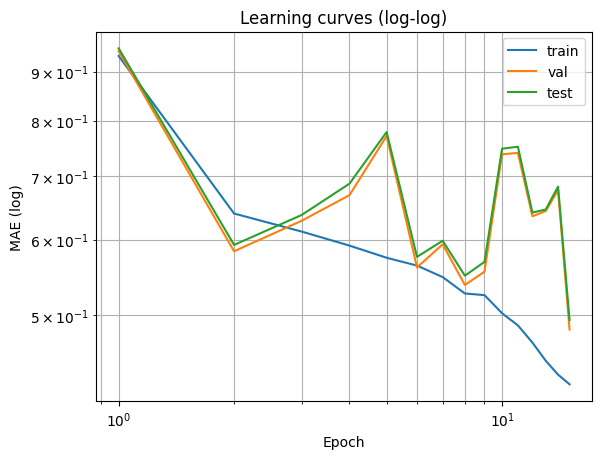

In [ ]:
# -- plot log-log learning curves
steps = np.arange(1, len(train_curve)+1)
plt.figure()
plt.loglog(steps, train_curve, label="train")
plt.loglog(steps, val_curve,   label="val")
plt.loglog(steps, test_curve,   label="test")
plt.xlabel("Epoch")
plt.ylabel("MAE (log)")
plt.legend()
plt.grid(True, which="both")
plt.title("Learning curves (log-log)")
plt.savefig(EXP_DIR / "loss_curve.png", dpi=150)
plt.show()

## Evaluate Model

In [ ]:
net.load_state_dict(torch.load(EXP_DIR / "last_weights.pt")['state_dict'])
net.eval()

C:\Users\Owner\AppData\Local\Temp\ipykernel_77124\1112413728.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(EXP_DIR / "last_weights.pt")[

ResNet(
  (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def evaluate_split(loader):
    net.eval()
    y_true_list = []
    y_pred_list = []
    with torch.no_grad(), autocast(device=DEVICE):
        for x, y in loader:
            x = x.to(DEVICE)
            # Get prediction and bring it to CPU
            pred = net(x).cpu().squeeze(1)
            # True values on CPU
            y_cpu = y.detach().cpu().float()
            # Append numpy arrays
            y_pred_list.append(pred.numpy())
            y_true_list.append(y_cpu.numpy())

    # Concatenate all batches
    y_true = np.concatenate(y_true_list)
    y_pred = np.concatenate(y_pred_list)
    errs = np.abs(y_pred - y_true)
    return y_true, y_pred, errs.mean(), errs.std()

# Evaluate for train, val, test
y_train, yhat_train, mae_train, std_train = evaluate_split(train_ld)
y_val, yhat_val, mae_val, std_val = evaluate_split(val_ld)
y_test, yhat_test, mae_test, std_test = evaluate_split(test_ld)

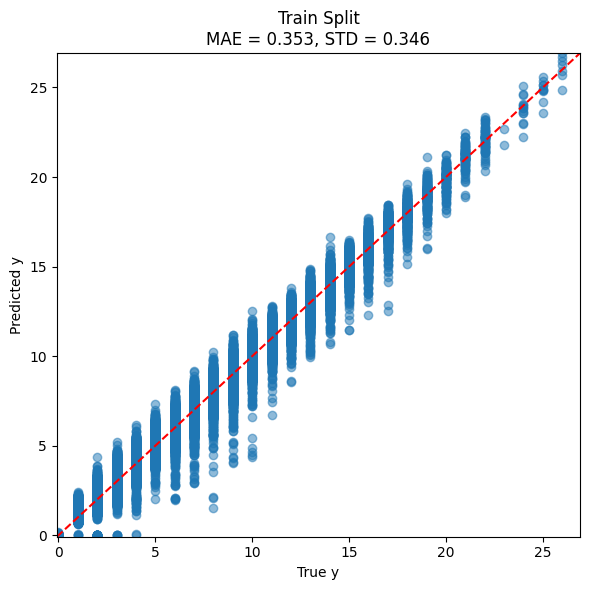

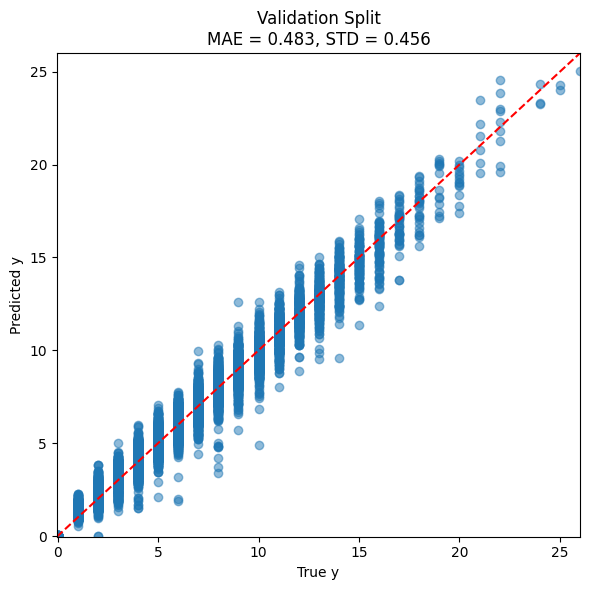

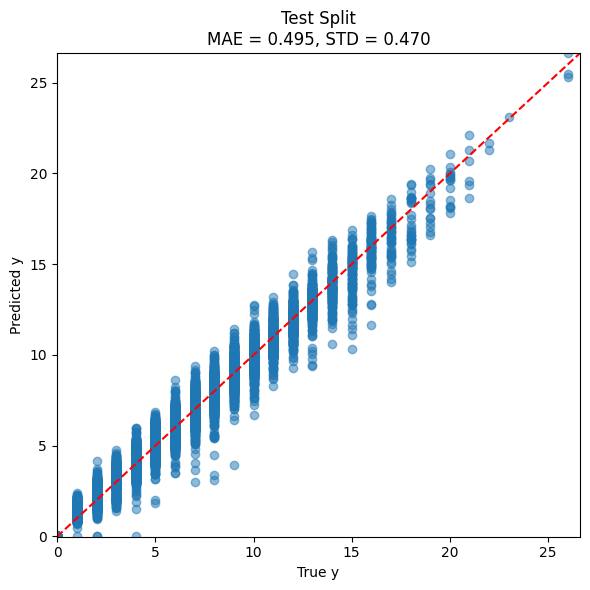

In [ ]:
# Scatter plot function
def plot_scatter(y_true, y_pred, mae, std, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    # 45-degree line for reference
    lims = [
        min(y_true.min(), y_pred.min()),
        max(y_true.max(), y_pred.max())
    ]
    plt.plot(lims, lims, 'r--')
    plt.xlabel('True y')
    plt.ylabel('Predicted y')
    plt.title(f'{title}\nMAE = {mae:.3f}, STD = {std:.3f}')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.tight_layout()
    plt.savefig(EXP_DIR / f"scatter_{title}.png", dpi=150)
    plt.show()

# Generate scatterplots
plot_scatter(y_train, yhat_train, mae_train, std_train, 'Train Split')
plot_scatter(y_val, yhat_val, mae_val, std_val, 'Validation Split')
plot_scatter(y_test, yhat_test, mae_test, std_test, 'Test Split')

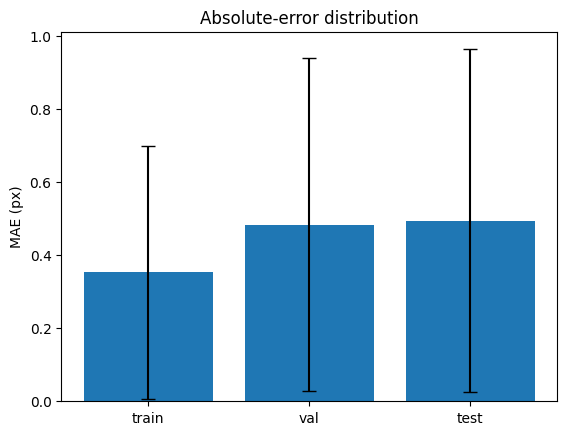

MAE  train 0.353 ± 0.346
MAE  val   0.483 ± 0.456
MAE  test  0.495 ± 0.470


In [ ]:
labels = ["train", "val", "test"]
means  = [mae_train, mae_val, mae_test]
stds   = [std_train, std_val, std_test]

plt.figure()
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("MAE (px)")
plt.title("Absolute-error distribution")
plt.savefig(EXP_DIR / "error_bars.png", dpi=150)
plt.show()

print(f"MAE  train {mae_train:.3f} ± {std_train:.3f}")
print(f"MAE  val   {mae_val:.3f} ± {std_val:.3f}")
print(f"MAE  test  {mae_test:.3f} ± {std_test:.3f}")

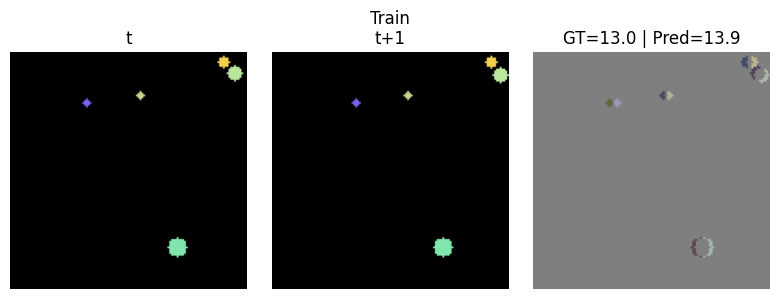

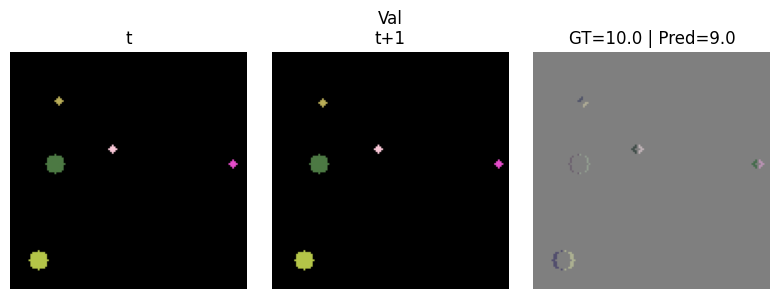

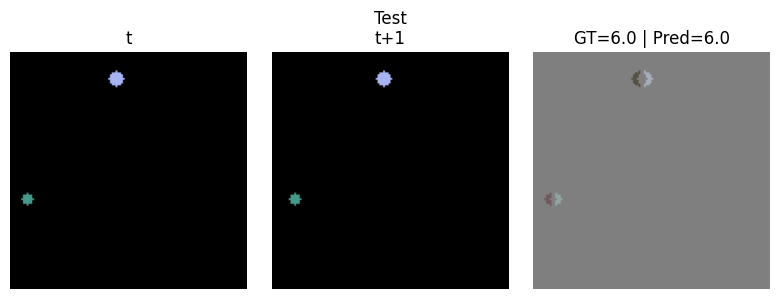

In [ ]:
def show_example(dataset, title_prefix=""):
    idx = random.randrange(len(dataset))
    (x, y_true) = dataset[idx]          # x: (C,H,W) float
    f0 = x[:3] if not USE_GRAYSCALE else x[0:1].repeat(3,1,1)
    f1 = x[3:6] if not USE_GRAYSCALE else x[1:2].repeat(3,1,1)
    diff = x[6:9] if not USE_GRAYSCALE else x[2:3].repeat(3,1,1)

    with torch.no_grad():
        pred = net(x.unsqueeze(0).to(DEVICE)).cpu().item()

    y_true = unnormalize(y_true, DISP_MEAN, DISP_STD)
    pred = unnormalize(pred, DISP_MEAN, DISP_STD)

    f0_img = f0.permute(1,2,0).numpy()
    f1_img = f1.permute(1,2,0).numpy()
    diff   = diff.permute(1,2,0).numpy()
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1); plt.imshow(f0_img); plt.title("t");     plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(f1_img); plt.title("t+1");   plt.axis("off")
    plt.subplot(1,3,3); plt.imshow((diff+1)/2, cmap="bwr", vmin=0, vmax=1)
    plt.title(f"GT={y_true:.1f} | Pred={pred:.1f}")
    plt.axis("off")
    plt.suptitle(title_prefix)
    plt.tight_layout()
    plt.savefig(EXP_DIR / f"{title_prefix}_prediction.png", dpi=150)
    plt.show()

# Show a few random examples from each split
for split_name, ds in [("Train", train_ds), ("Val", val_ds), ("Test", test_ds)]:
    show_example(ds, title_prefix=split_name)

In [ ]:
idx = random.randrange(len(ds))
(x, y_true) = ds[idx]          # x: (C,H,W) float
f0 = x[:3] if not USE_GRAYSCALE else x[0:1].repeat(3,1,1)
f1 = x[3:6] if not USE_GRAYSCALE else x[1:2].repeat(3,1,1)
diff = x[6:9] if not USE_GRAYSCALE else x[2:3].repeat(3,1,1)

In [ ]:
diff.max()

tensor(0.4765)